In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

loading csv files from google drive

In [3]:
directory = '/content/drive/My Drive/NBA Season Data/2015-16'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [4]:
files.keys()

dict_keys(['hand_off', 'cut', 'drives', 'off_screen', 'screen_assists', 'assists', 'pnr_handler', 'post_up', 'putback', 'height_weight', 'box_scores', 'catch_and_shoot', 'pnr_man', 'touches', 'spot_up', 'isolation', 'shot_chart'])

In [5]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: hand_off
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER        233 non-null    object 
 1   TEAM          233 non-null    object 
 2   HANDOFF FREQ  233 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.6+ KB

STAT: cut
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PLAYER    334 non-null    object 
 1   TEAM      334 non-null    object 
 2   CUT FREQ  334 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.0+ KB

STAT: drives
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYER          476 non-null    object 

merging dataframes

In [6]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               233 non-null    object 
 1   TEAM                 233 non-null    object 
 2   HANDOFF FREQ         233 non-null    float64
 3   CUT FREQ             184 non-null    float64
 4   DRIVES               215 non-null    float64
 5   PASS OFF DRIVE       215 non-null    float64
 6   OFF SCREEN FREQ      190 non-null    float64
 7   SCREEN ASSISTS       215 non-null    float64
 8   PASSES MADE          215 non-null    float64
 9   PNR HANDLER FREQ     221 non-null    float64
 10  POST UPS             215 non-null    float64
 11  PUTBACK FREQ         149 non-null    float64
 12  HEIGHT               215 non-null    object 
 13  WEIGHT               215 non-null    float64
 14  MIN                  215 non-null    float64
 15  FGA                  215 non-null    flo

In [7]:
directory = '/content/drive/My Drive/NBA Season Data/2015-16'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players15_16 = pd.DataFrame()
for stat in files.keys():
  if players15_16.empty:
    players15_16 = files[stat]
  else:
    players15_16 = pd.merge(players15_16, files[stat], how="left", on = ["PLAYER", "TEAM"])

players15_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               233 non-null    object 
 1   TEAM                 233 non-null    object 
 2   HANDOFF FREQ         233 non-null    float64
 3   CUT FREQ             184 non-null    float64
 4   DRIVES               215 non-null    float64
 5   PASS OFF DRIVE       215 non-null    float64
 6   OFF SCREEN FREQ      190 non-null    float64
 7   SCREEN ASSISTS       215 non-null    float64
 8   PASSES MADE          215 non-null    float64
 9   PNR HANDLER FREQ     221 non-null    float64
 10  POST UPS             215 non-null    float64
 11  PUTBACK FREQ         149 non-null    float64
 12  HEIGHT               215 non-null    object 
 13  WEIGHT               215 non-null    float64
 14  MIN                  215 non-null    float64
 15  FGA                  215 non-null    flo

In [8]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'RESTRICTED AREA FGA', 'IN THE PAINT FGA', 'MID RANGE FGA', 'ABOVE THE BREAK FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'RESTRICTED AREA FGA': 'RESTRICTED AREA FREQ', 'IN THE PAINT FGA': 'IN THE PAINT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'ABOVE THE BREAK FGA': 'ABOVE THE BREAK FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [9]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players15_16_clean = preprocess_pipeline.fit_transform(players15_16)
cluster15_16 = cluster_pipeline.fit_transform(players15_16_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result15_16 = pd.concat([players15_16_clean, cluster15_16], axis=1)
result15_16

should fire twice
something


<ipython-input-8-bb64d28d10d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-8-bb64d28d10d5>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-8-bb64d28d10d5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,PLAYER,TEAM,HANDOFF FREQ,CUT FREQ,DRIVES PER TOUCHES,PASS OFF DRIVE,OFF SCREEN FREQ,SCREEN ASSISTS,PASSES PER TOUCHES,PNR HANDLER FREQ,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,JJ Redick,LAC,18.5,1.4,8.045977,0.357143,38.7,0.0,58.045977,5.5,...,0,6.260038,8.459447,7.509957,8.224268,10.165130,14.132801,10.792824,10.845349,0.110071
1,Avery Bradley,BOS,17.2,4.6,4.663212,0.166667,14.6,0.0,57.772021,13.5,...,2,5.339262,6.231402,5.011783,6.324116,8.162021,12.166413,8.699403,7.755888,0.056380
2,Isaiah Thomas,BOS,9.3,1.7,19.503546,0.357576,8.6,0.0,70.567376,31.0,...,4,8.889620,6.165176,7.397298,5.351014,3.022327,13.822604,10.452447,9.626006,0.293828
3,Khris Middleton,MIL,10.3,2.1,10.608696,0.327869,11.8,0.0,64.521739,18.0,...,1,5.508783,2.584527,4.542184,5.175455,5.784178,10.215992,6.886622,6.978505,0.166838
4,Gordon Hayward,UTA,11.5,3.9,17.185185,0.327586,7.5,0.0,66.962963,24.4,...,1,5.800032,2.910697,4.177890,4.782848,5.119034,10.867757,7.176876,6.582323,0.080615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Frank Kaminsky,CHA,1.7,9.4,6.542056,0.285714,2.9,0.0,79.906542,0.0,...,6,7.340219,7.836175,6.376915,8.574538,9.893657,8.264521,2.725148,5.992301,0.326317
191,Iman Shumpert,CLE,3.4,0.0,8.960573,0.280000,4.9,0.0,72.043011,15.3,...,2,3.716992,5.243620,3.194993,4.307273,6.971535,11.735291,7.171284,6.392263,0.085930
192,Markel Brown,BKN,3.8,4.5,9.051724,0.333333,8.8,0.0,67.672414,23.6,...,2,4.321307,4.258349,2.436686,3.933514,5.793534,10.959137,6.793302,5.248307,0.191394
193,Metta World Peace,LAL,9.1,0.0,6.896552,0.071429,0.0,0.0,66.995074,10.0,...,2,6.079110,6.258518,5.085733,7.420207,9.102697,10.578346,6.410212,6.137596,0.124013


In [10]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

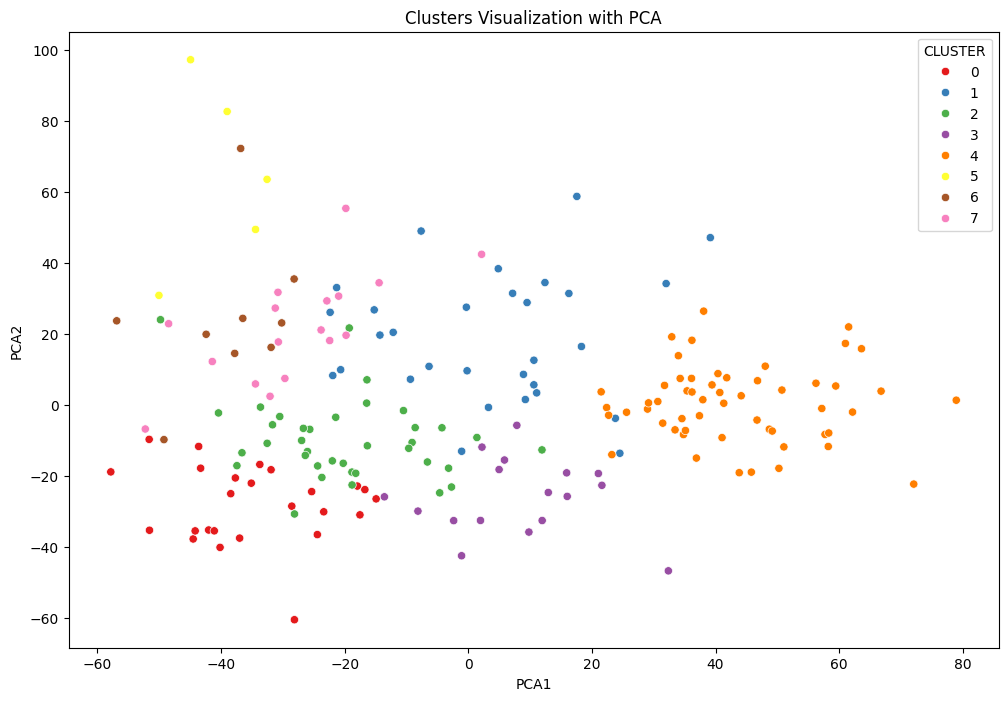

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result15_16.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result15_16['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [11]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result15_16.loc[result15_16['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
0              JJ Redick
18           Kyle Korver
30              CJ Miles
32      Robert Covington
39       Hollis Thompson
40          Allen Crabbe
51          Nik Stauskas
55              JR Smith
63       Wesley Matthews
64       Marco Belinelli
72          Trevor Ariza
79             O.J. Mayo
93        Wesley Johnson
97            Nick Young
102           Joe Ingles
103    Richard Jefferson
108      Wayne Ellington
117      Mirza Teletovic
119        Terrence Ross
123       Nikola Mirotic
126          Jason Terry
141     Tim Hardaway Jr.
155        Mike Dunleavy
161          Danny Green
163        Anthony Brown
Name: PLAYER, dtype: object

CLUSTER 1
3        Khris Middleton
4         Gordon Hayward
6          Nicolas Batum
11        Andrew Wiggins
19         Kawhi Leonard
20        Victor Oladipo
22        Jamal Crawford
24           Paul George
25          Jimmy Butler
28         DeMar DeRozan
33      Danilo Gallinari
34           Kobe Bryant
41           Will Barton
4

In [12]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result15_16.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,JJ Redick,0,0.110071,6.260038,8.459447,7.509957,8.224268,10.165130,14.132801,10.792824,10.845349
1,Avery Bradley,2,0.056380,5.339262,6.231402,5.011783,6.324116,8.162021,12.166413,8.699403,7.755888
2,Isaiah Thomas,4,0.293828,8.889620,6.165176,7.397298,5.351014,3.022327,13.822604,10.452447,9.626006
3,Khris Middleton,1,0.166838,5.508783,2.584527,4.542184,5.175455,5.784178,10.215992,6.886622,6.978505
4,Gordon Hayward,1,0.080615,5.800032,2.910697,4.177890,4.782848,5.119034,10.867757,7.176876,6.582323
...,...,...,...,...,...,...,...,...,...,...,...
190,Frank Kaminsky,6,0.326317,7.340219,7.836175,6.376915,8.574538,9.893657,8.264521,2.725148,5.992301
191,Iman Shumpert,2,0.085930,3.716992,5.243620,3.194993,4.307273,6.971535,11.735291,7.171284,6.392263
192,Markel Brown,2,0.191394,4.321307,4.258349,2.436686,3.933514,5.793534,10.959137,6.793302,5.248307
193,Metta World Peace,2,0.124013,6.079110,6.258518,5.085733,7.420207,9.102697,10.578346,6.410212,6.137596


# 2015-2016 Season Clusters

In [13]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

for i in range(8):
  print(f"CLUSTER {i}")
  print(result15_16.loc[result15_16['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
0              JJ Redick
18           Kyle Korver
30              CJ Miles
32      Robert Covington
39       Hollis Thompson
40          Allen Crabbe
51          Nik Stauskas
55              JR Smith
63       Wesley Matthews
64       Marco Belinelli
72          Trevor Ariza
79             O.J. Mayo
93        Wesley Johnson
97            Nick Young
102           Joe Ingles
103    Richard Jefferson
108      Wayne Ellington
117      Mirza Teletovic
119        Terrence Ross
123       Nikola Mirotic
126          Jason Terry
141     Tim Hardaway Jr.
155        Mike Dunleavy
161          Danny Green
163        Anthony Brown
Name: PLAYER, dtype: object

CLUSTER 1
3        Khris Middleton
4         Gordon Hayward
6          Nicolas Batum
11        Andrew Wiggins
19         Kawhi Leonard
20        Victor Oladipo
22        Jamal Crawford
24           Paul George
25          Jimmy Butler
28         DeMar DeRozan
33      Danilo Gallinari
34           Kobe Bryant
41           Will Barton
4